In [1]:
import awswrangler as wr
# import lux
import pandas as pd
import numpy as np
import copy
import pickle


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from surprise import SVD, KNNBasic, NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import KNNBaseline, SVD
from surprise import get_dataset_dir
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD



import warnings
warnings.filterwarnings("ignore")

In [2]:
filename = '../data/processed/final_beer_df.plk'
final_df = pd.read_pickle(filename)


In [3]:
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3405148 entries, 0 to 4026233
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brewery_name    string 
 1   beer_name       string 
 2   beer_style      string 
 3   beer_sub_style  string 
 4   user_name       string 
 5   user_rating     float64
 6   rating          float64
 7   rating_count    Int64  
 8   review_count    Int64  
 9   ba_score        float64
 10  abv             float64
dtypes: Int64(2), float64(4), string(5)
memory usage: 318.2 MB


In [4]:
print('Original number of unique beers: {}'.format(len(final_df.beer_name.unique())))

print('Revised number of unique beers: {}'.format(len(final_df.beer_name.unique())))


Original number of unique beers: 8216
Revised number of unique beers: 8216


In [5]:
final_df

,brewery_name,beer_name,beer_style,beer_sub_style,user_name,user_rating,rating,rating_count,review_count,ba_score,abv
0,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,StanleysCup,3.77,3.67,3987,1144,83.0,4.3
1,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,TwilightBeerCareer,3.58,3.67,3987,1144,83.0,4.3
2,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,Chipwells,3.50,3.67,3987,1144,83.0,4.3
3,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,GaryM6,3.62,3.67,3987,1144,83.0,4.3
4,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,uncleotis,3.82,3.67,3987,1144,83.0,4.3
...,...,...,...,...,...,...,...,...,...,...,...
4026229,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,XmnwildX12,4.73,4.56,896,136,100.0,11.5
4026230,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,Hawkfish,4.62,4.56,896,136,100.0,11.5
4026231,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,Appearanceswc,4.73,4.56,896,136,100.0,11.5
4026232,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,paulish,4.75,4.56,896,136,100.0,11.5


In [6]:


# create beerID for each beer

grouped_name = final_df.groupby('beer_name')

temp_df = grouped_name.count()
temp_df_idx = pd.DataFrame(temp_df.index)


temp_df_idx['beer_id'] = temp_df_idx.index
dict_df=temp_df_idx[['beer_id','beer_name']]


desc_dict = dict_df.set_index('beer_name').to_dict()
new_dict = desc_dict['beer_id']

final_df['beer_id'] = final_df.beer_name.map(new_dict)



# create userID for each user
grouped_user = final_df.groupby('user_name')

temp_df_user = grouped_user.count()
temp_df_user_idx = pd.DataFrame(temp_df_user.index)


temp_df_user_idx['user_id'] = temp_df_user_idx.index
dict_df_user = temp_df_user_idx[['user_id','user_name']] 


desc_dict_user = dict_df_user.set_index('user_name').to_dict()
new_dict_user = desc_dict_user['user_id']

final_df['user_id'] = final_df.user_name.map(new_dict_user)

In [7]:

def read_item_names():
    """
    return raw ids  beer names into raw ids.
    """


    file_name = dict_df
    rid_to_name = {}
    name_to_rid = {}

    # there are 3959 unique beers after removing the low rating and review count beers
    unique_beers = len(final_df.beer_name.unique())
    
    for i in range(unique_beers):  
        line = file_name.iloc[i]
        rid_to_name[line[0]] = line[1]
        name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid


The following functions are from 
https://surprise.readthedocs.io/en/stable/FAQ.html 
and change slightly for my use case.

In [8]:
def get_top_n(beer_name, k):
    """
    Input Beer name and returns k recommendations
    based on item similarity
    
    Input: String, integer
    Output: String
    """
    
    rid_to_name, name_to_rid = read_item_names()

    beer_input_raw_id = name_to_rid[beer_name]
    beer_input_inner_id = algo.trainset.to_inner_iid(beer_input_raw_id)

        
    beer_input_neighbors = algo.get_neighbors(beer_input_inner_id, k=k)

    beer_input_neighbors = (algo.trainset.to_raw_iid(inner_id) for inner_id in beer_input_neighbors)
    
    beer_input_neighbors = (rid_to_name[rid]  for rid in beer_input_neighbors)

        
    return list(beer_input_neighbors)

In [9]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(final_df[['user_id', 'beer_id', 'user_rating']], reader)
trainset = data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [10]:

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1319  0.1321  0.1314  0.1316  0.1315  0.1317  0.0003  
MAE (testset)     0.0548  0.0549  0.0546  0.0547  0.0547  0.0547  0.0001  
Fit time          231.64  229.40  232.90  218.15  220.06  226.43  6.11    
Test time         913.56  893.28  867.97  866.70  866

{'test_rmse': array([0.13193311, 0.13206942, 0.13138204, 0.13158857, 0.13149125]),
 'test_mae': array([0.05484153, 0.05492662, 0.05458134, 0.05473659, 0.05465127]),
 'fit_time': (231.63984990119934,
  229.4035792350769,
  232.89582896232605,
  218.15292072296143,
  220.06071996688843),
 'test_time': (913.5596232414246,
  893.275573015213,
  867.9717540740967,
  866.6980929374695,
  866.2086560726166)}

In [11]:
# top 20 most rated beers
grouped_beer_names = final_df.groupby('beer_name')
grouped_beer_names.count().sort_values(by='user_name', ascending=False)[0:21].index.tolist()

['Porter',
 'Pale Ale',
 'Oktoberfest',
 'KBS (Kentucky Breakfast Stout)',
 'Bourbon County Brand Stout',
 'Zombie Dust',
 'Ten FIDY',
 'Abt 12',
 'Trappistes Rochefort 10',
 'Samuel Adams Boston Lager',
 'Christmas Ale',
 'Fat Tire Amber Ale',
 'IPA',
 'Hefeweissbier',
 'Pumpkin Ale',
 'Backwoods Bastard',
 'Nugget Nectar',
 'Nut Brown Ale',
 'Dirty Bastard',
 'Samuel Adams Octoberfest',
 'Dead Guy Ale']

In [12]:
grouped_beer_names.mean().sort_values(by='user_rating', ascending=False)[0:21].index.tolist()

['Vanilla Bean Assassin',
 'Barrel Aged Imperial German Chocolate Cupcake Stout',
 'Blessed',
 'Ann',
 'Maman',
 'A Deal With The Devil - Double Oak-Aged',
 'Hypermash Hydra',
 'Assassin',
 'Bourbon County Brand Stout',
 'Anabasis',
 "Mornin' Delight",
 'Everett (Barrel Aged)',
 'Trappist Westvleteren 12 (XII)',
 'Barrel-Aged Abraxas',
 'Aaron',
 'CBS (Canadian Breakfast Stout)',
 'Barrel-Aged Henna - Double Rainbow',
 'It Was All A Dream',
 'Kentucky Brunch Brand Stout',
 'West Ashley',
 'Rare Scooop']

In [13]:
get_top_n('Pumpkin Ale', 20)

['Victory At Sea - Coffee And Vanilla',
 'Leffe Blonde',
 'Bigfoot',
 'Bomb!',
 "G'Knight",
 'Tap 6 Aventinus',
 'Old Speckled Hen',
 'Old Stock Ale',
 'Hoegaarden Original White Ale',
 'Scrimshaw Pilsner',
 'Scotty Karate Scotch Ale',
 'Fort',
 'Traditional Lager',
 '1554',
 'Espresso Oak Aged Yeti Imperial Stout',
 'Jinx Proof',
 'Brawler Champion Ale',
 'Third Coast Beer',
 'Asahi Super Dry',
 'Mosaic Promise']

In [14]:
get_top_n('Vanilla Bean Assassin', 20)

['Fort Point Pale Ale',
 "Hunahpu's Imperial Stout",
 'Trappist Westvleteren 8 (VIII)',
 'Hefeweizen',
 'Harvest Ale (Limited Edition)',
 'Apple Brandy Barrel Noir',
 'Imperial Stout',
 'CascaZilla',
 'A Deal With The Devil',
 'Flora - Blueberry',
 'X',
 'Art',
 "Mornin' Delight",
 'A Night To End All Dawns',
 "Peche 'n Brett",
 'Mocha Wednesday',
 'Big Bad Baptista',
 'Triple Shot',
 'Traquair House Ale',
 'Last Buffalo In The Park']

In [15]:
top20rated = final_df.groupby('beer_name').count().sort_values(by='user_name', ascending =False)[0:21].index.tolist()
top20rated = set(top20rated)

top20rating = final_df.groupby('beer_name').mean().sort_values(by='user_rating', ascending =False)[0:21].index.tolist()
top20rating = set(top20rating)

beer_1 = set(get_top_n('Ichabod Ale',20))
beer_2 = set(get_top_n('Jinx',20))


In [16]:
print(beer_1.intersection(top20rated))
print(beer_1.intersection(top20rating))


set()
set()


In [17]:
print(beer_2.intersection(top20rated))
print(beer_2.intersection(top20rating))

{'Fat Tire Amber Ale'}
set()


In [18]:
final_df_pivot = final_df.pivot_table(index='user_name', columns='beer_name', values='user_rating').fillna(0)

In [19]:
final_df

,brewery_name,beer_name,beer_style,beer_sub_style,user_name,user_rating,rating,rating_count,review_count,ba_score,abv,beer_id,user_id
0,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,StanleysCup,3.77,3.67,3987,1144,83.0,4.3,3451,14937
1,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,TwilightBeerCareer,3.58,3.67,3987,1144,83.0,4.3,3451,16404
2,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,Chipwells,3.50,3.67,3987,1144,83.0,4.3,3451,3365
3,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,GaryM6,3.62,3.67,3987,1144,83.0,4.3,3451,6123
4,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,uncleotis,3.82,3.67,3987,1144,83.0,4.3,3451,28872
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026229,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,XmnwildX12,4.73,4.56,896,136,100.0,11.5,4216,17176
4026230,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,Hawkfish,4.62,4.56,896,136,100.0,11.5,4216,6795
4026231,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,Appearanceswc,4.73,4.56,896,136,100.0,11.5,4216,858
4026232,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,paulish,4.75,4.56,896,136,100.0,11.5,4216,26027


In [20]:
final_df_pivot.info()


<class 'pandas.core.frame.DataFrame'>
Index: 29616 entries, ------ to zzachm18
Columns: 8216 entries, """Admiral"" Stash" to 日本から来たネコ (Some Cat From Japan)
dtypes: float64(8216)
memory usage: 1.8+ GB


In [21]:
final_df_pivot_T = final_df_pivot.values.T
final_df_pivot_T.shape


(8216, 29616)

In [22]:

def exp_var(list_n_components):
    
    out = []
    
    for num in list_n_components:
        SVD = TruncatedSVD(n_components=num,random_state=num)
        SVD.fit_transform(final_df_pivot_T)
        evar = np.sum(SVD.explained_variance_ratio_)
        t = (num,evar)
        out.append(t)
    
    return out

In [23]:
n_comp = [5,10,20,50,100,200,300,400,600,900,1200]
explained_variance = exp_var(n_comp)

In [24]:
[print(i) for i in explained_variance]


(5, 0.024729628565855182)
(10, 0.04082514005015338)
(20, 0.06586834057091329)
(50, 0.1169198307150372)
(100, 0.17675228910228682)
(200, 0.26342708728228764)
(300, 0.32920699847508195)
(400, 0.38329387400209436)
(600, 0.469828610741911)
(900, 0.5664451797965855)
(1200, 0.6386898744232761)


[None, None, None, None, None, None, None, None, None, None, None]

Text(0.5, 1.0, 'Percentage of Explained Variance by Component Count')

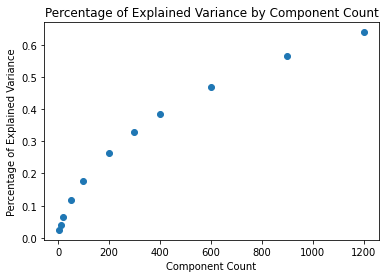

In [57]:
x, y = zip(*explained_variance)
plt.scatter(x, y)
plt.xlabel('Component Count')
plt.ylabel('Percentage of Explained Variance')
plt.title("Percentage of Explained Variance by Component Count")

In [26]:
SVD900 = TruncatedSVD(n_components=900, random_state=43)
matrix900 = SVD900.fit_transform(final_df_pivot_T)
matrix900.shape


(8216, 900)

In [27]:
corr900 = np.corrcoef(matrix900)
corr900.shape

(8216, 8216)

In [28]:

# name of all beers
beer_rec_names900 = final_df_pivot.columns

# list of all beer names
beer_rec_list900 = list(beer_rec_names900)

In [29]:
def svd900_top_n(string, n):
    
    # get index of beer name from list of all beers in the training data
    get_index = beer_rec_list900.index(string)
    
    # similarity coeff of all other beers w respect to the input beer
    similarities = corr900[get_index]
    
    # create  & popluate list to hold tuples of beer names and their 
    # respective correlation coeff, sorted in reverse
    closest = []    
    for idx, coeff in enumerate(similarities):
        closest.append((beer_rec_list900[idx], coeff))
    
    closest.sort(key=lambda x: x[1], reverse=True)
    
    out = []
    
    for i in range(1,n+1):
        out.append(closest[i][0])
    return out

In [39]:
svd900_top_n('Samuel Adams Boston Lager', 40)

['Fat Tire Amber Ale',
 'Negra Modelo',
 'Samuel Adams Octoberfest',
 'Hoegaarden Original White Ale',
 'Goose IPA',
 'Anchor Porter',
 'Traditional Lager',
 'Dead Guy Ale',
 'Guinness Foreign Extra Stout',
 'Kalamazoo Stout',
 'Anchor Steam Beer',
 'Snowdrift Vanilla Porter',
 'Samuel Adams Cold Snap',
 'Samuel Adams Winter Lager',
 'Born Yesterday',
 'Pilsner Urquell',
 'Hofbräu Original',
 'Blue',
 'Baltimore Blonde',
 'Edmund Fitzgerald',
 'Ten FIDY',
 'Bigfoot',
 'Solid Gold',
 'Hazelnut Brown Nectar',
 "Smithwick's Imported Premium Irish Ale",
 'Sublimely Self-Righteous Black IPA',
 'Midnight Lager',
 'Boddingtons Pub Ale',
 "Dragon's Milk",
 'Erdinger Weissbier (Hefe-Weizen)',
 'Xocoveza',
 'Blue Moon Harvest Pumpkin Wheat',
 'Samuel Adams Summer Ale',
 'Taddy Porter',
 'Black Butte Porter',
 'Samuel Adams Alpine Lager',
 'Hefe-Weissbier Naturtrüb',
 'Dirty Bastard',
 'Grolsch Premium Lager',
 'Prima Pils']

In [40]:
get_top_n('Samuel Adams Boston Lager', 40)

['Nugget Nectar',
 'The Abyss',
 'Three Philosophers',
 'Punkin Ale',
 'Traditional Lager',
 "Dragon's Milk",
 'Bomb!',
 'Orval Trappist Ale',
 'Samuel Adams Summer Ale',
 '#9',
 'Ayinger Celebrator',
 'Péché Mortel',
 'Maudite',
 'Mirror Pond Pale Ale',
 'Leffe Blonde',
 'Kellerweis',
 'Raging Bitch',
 'Hop Head Red Ale',
 'Vitus',
 'Old Stock Ale',
 'Banana Bread Beer',
 'Troegenator',
 'The Sixth Glass Quadrupel Ale',
 'Best Brown Ale',
 'Hopback Amber Ale',
 'Flipside Red IPA',
 'Warlock',
 'Tap 9 Aventinus Eisbock',
 'Gonzo',
 'East IPA',
 'London Porter',
 'Red Chair NWPA',
 'Pannepot',
 'Blushing Monk',
 'La Trappe Quadrupel (Koningshoeven / Dominus)',
 'Skull Splitter',
 'Ayinger Bräuweisse',
 'Raspberry Tart',
 'Chainbreaker White IPA',
 'India Ale']

In [41]:
A = set(svd900_top_n('Samuel Adams Boston Lager', 40))
B = set(get_top_n('Samuel Adams Boston Lager', 40))
print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))


common beers: {'Traditional Lager', "Dragon's Milk", 'Samuel Adams Summer Ale'}
number of common beers: 3


In [42]:
from tqdm import tqdm
def compare_recs(name_list,n):

    results = []
    
    for idx, name in tqdm(enumerate(name_list)):
        svd = set(svd900_top_n(name,n))
        knn = set(get_top_n(name,n))
        common = len(svd.intersection(knn))
        tup = (idx, common)
        results.append(tup)
    
    x,y = zip(*results)
    plt.scatter(x, y)
    plt.xlabel('Unique Beer No.')
    plt.ylabel('Common Recommendations')
    plt.show()


In [50]:
grouped = final_df.groupby('beer_name')
namelist = grouped.mean().sort_values(by='rating', ascending=False)[::82].index.tolist()


101it [01:46,  1.06s/it]


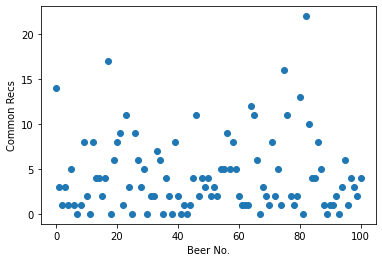

In [51]:
compare_recs(namelist, 100)


101it [01:47,  1.06s/it]


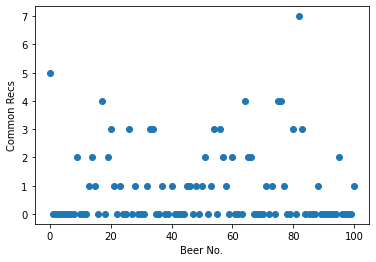

In [53]:
compare_recs(namelist, 50)
